## Imports


In [3]:
import requests
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote, quote_plus
import re
import codecs
import zipfile
import csv
from urllib.parse import quote
from requests.exceptions import RequestException
import os
import numpy as np
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import ast
import os
import csv
import requests
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from urllib.parse import quote
import zipfile
import re
import shutil
import unicodedata
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Ignore InsecureRequestWarning
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

## 1


Get one recipe


In [5]:
title = "Ferges\u00eb_e_Tiran\u00ebs_me_piperka_(Tirana_fergese_with_peppers)"
title = title.replace("/", "_").replace(":", "_").replace(" ", "_")
title = "".join(quote(c) if not c.isascii() else c for c in title)
print(title)

baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
query_title = "titles=" + title
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}{}&{}&{}&{}".format(baseurl, action, query_title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

Ferges%C3%AB_e_Tiran%C3%ABs_me_piperka_(Tirana_fergese_with_peppers)
https://en.cookipedia.co.uk/wiki/api.php?action=query&titles=Ferges%C3%AB_e_Tiran%C3%ABs_me_piperka_(Tirana_fergese_with_peppers)&prop=revisions&rvprop=content&format=json


get the list of countries


In [6]:
baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
title = "titles=" + quote(
    "Template:CategoryRecipesCountry"
)  # URL encode the title and add 'titles='
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}&{}&{}&{}".format(baseurl, action, title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

pattern = r"\[\[:Category:([^|\]]+)\|"

# Find all matches
countries = re.findall(pattern, wikitext)

# Print the matches
for country in countries:
    print(country)
print(len(countries))

https://www.cookipedia.co.uk/wiki/api.php?&action=query&titles=Template%3ACategoryRecipesCountry&prop=revisions&rvprop=content
Albanian_recipes
Algerian_recipes
Armenian_recipes
Austrian_recipes
Australian_recipes
Belgian_recipes
British_recipes
Bulgarian_recipes
Chilean_recipes
Chinese_recipes
Cuban_recipes
Czech recipes
Danish recipes
Dutch recipes
Ecuadorian recipes
Finnish recipes
French_recipes
German_recipes
Greek recipes
Hungarian_recipes
Indian recipes
Indonesian recipes
Irish recipes
Italian recipes
Jamaican recipes
Korean recipes
Latin American recipes
Lebanese recipes
Libyan recipes
Luxembourg_recipes
Mauritian recipes
Mexican recipes
Middle Eastern recipes
Moroccan recipes
North African recipes
North American recipes
Norwegian recipes
Oriental cuisine
Paraguayan recipes
Peruvian_recipes
Polish_recipes
Portuguese recipes
Romanian recipes
Russian recipes
Serbian recipes
Spanish recipes
Swedish recipes
Swiss recipes
Syrian recipes
Tex-Mex recipes
Thai recipes
Tunisian recipes


## Get recipe titles for each country


In [7]:
with open("recipe_titles.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Country", "Recipe Title"])  # Write the header

    # Loop through each country
    for country in countries:
        baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
        action = "action=query"
        list = "list=categorymembers"  # Get a list of pages in the category
        cmtitle = "cmtitle=" + quote(
            "Category:" + country
        )  # URL encode the category name and add 'cmtitle='
        dataformat = "format=json"
        cmcontinue = ""

        while True:
            # Combine parameters in the correct order, including cmcontinue for pagination
            query = "{}&{}&{}&{}".format(baseurl, action, list, cmtitle, dataformat)
            if cmcontinue:
                query += "&cmcontinue=" + cmcontinue

            wikiresponse = requests.get(query, verify=False)
            wikitext = wikiresponse.text

            # Parse the response as text to get the recipe titles
            recipe_titles = re.findall(r'"title": "(.+?)"', str(wikitext))

            for recipe_title in recipe_titles:
                recipe_title = (
                    recipe_title.replace("/", "_").replace(":", "_").replace(" ", "_")
                )
                print(recipe_title)
                writer.writerow([country, recipe_title])

            match = re.search(r'"cmcontinue": "(.*?)"', wikitext)
            if match:
                cmcontinue = match.group(1)
            else:
                break

Byrek_me_spinaq_(Spinach_pie)
Chilled_yoghurt_and_cucumber_soup_(tarator)
Chilled_yogurt
Comlek_(Rabbit_casserole_with_onions_and_wine_vinegar)
Ferges\u00eb_e_Tiran\u00ebs_me_piperka_(Tirana_fergese_with_peppers)
Fish_stew_from_Tirana
Garlic_and_walnut_sauce
Gjell\u00eb_me_arra_(Chicken_with_walnuts)
Jani_me_fasule_(Bean_soup)
Mehudehra_(Albanian_Garlic_soup)
Qofte_t\u00eb_f\u00ebrguara_(Fried_rissoles)
Tave_me_presh_(Baked_leeks)
Tirana_romaine_salad
Arnab_bil_tomatich_(Rabbit_with_tomato)
Brouklou_bil_dersa_(Cauliflower_in_dersa_sauce)
Bulghur_wheat_salad
Carrot_salad_with_grapefruit_and_orange_flower_water
Chalda_loubia_khadra_(Green_beans_with_almonds)
Chermoula
Chickpea_salad_with_red_onions_goats_cheese_and_paprika
Djedj_b'l-qasbour_(Stewed_chicken)
El_ham_lahou_(Ramadan_lamb)
Hut_bil_karfas_(Baked_fish_and_celery)
Kesksou_bil_djedj_(Couscous_with_chicken)
Kesksou_bil_djedj_-_couscous_with_chicken_(slow_cooker_recipe)
Lamb_meatballs
Osbane_es'smid_(Meat_soup_with_semolina_dumplin

## Create zip with recipes for each country


get all recipe texts in a zip, each file's name is the title (there are duplicates, because some recipes appeart in multiple countries)


In [8]:
def extract_ingredients(recipe_text):
    # Regex to get values between {{RecipeIngredients and ===Method=== parts
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Simplified regex to get the first word after [[
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()


txt = """
title\": "Ararat pilav (Rice with fruit)",
                "revisions": [
                    {
                        "contentformat": "text/x-wiki",
                        "contentmodel": "wikitext",
                        "*": "<!-- seo -->\n{{#seo:\n|title=Ararat pilav (Rice with fruit) a fruit recipe\n|titlemode=replace\n|keywords=#rice #butter #brandy #prunes #cinnamon #sultanas #stock #dried #apples #boiling #fry \n|hashtagrev=032020\n|description=A festive recipe from Armenia. You will need to soak the apricots and prunes overnight\n}}\n<!-- /seo -->\n\n{{Template:CookTools}}\n{{Template:AdvancePreparationIcon}}\n{{recipesummary\n|TotalCalories = 3232\n|PortionCalories = 808\n|DatePublished=27th October 2012\n|Author=Chef\n| ImageComment = Leaving Yerevan (''Armenia'') .. .. in an empty train\n |Servings = Serves 4\n |Difficulty = 2\n |TotalTime = 12 hours 40 minutes\n |PrepTime = 12 hours 10 minutes\n |CookTime = 30 minutes\n |Image = [[Image:Leaving Yerevan in an empty train.jpg|alt=Electus]]\n<span class=\"review\"> <span class=\"reviewHeader\">\n====Best recipe review====\n</span>\n''<span class=\"reviewTitle\">Overnight soak?</span>''\n\n<span style=\"line-height:180%\"><span style=\"font-size:180%;\"><span class=\"reviewScore\">3</span>/5</span>\n\n<span class=\"reviewDesc\">I always do, or it would be dry rice</span>\n\n<span class=\"reviewAuthor\"> [[User:PSmith|Paul&nbsp;R&nbsp;Smith]] </span></span>\n\n}}\nA festive recipe from Armenia.  You will need to soak the [[Apricots|apricots]] and [[Prunes|prunes]] overnight.\n\n'''For the [[Rice|rice]]'''\n{{RecipeIngredients\n| 50 g [[Butter|butter]]\n| 350 g [[Long grain rice|long grain rice]], washed under cold running water and drained\n| 1 teaspoon [[Salt|salt]]\n| 900 ml [[Boiling|boiling]] [[Stock|stock]] or water\n}}\n'''For the pilav'''\n{{RecipeIngredientsNB\n| 50 g [[Butter|butter]]\n| 75 g [[Blanched|blanched]] [[Almonds|almonds]]\n| 100 g [[Dried apricots|dried apricots]], soaked overnight, drained and coarsely chopped\n| 100 g stoned, [[Dried|dried]] [[Prunes|prunes]], soaked overnight, drained and coarsely chopped\n| 175 g [[Sultanas|sultanas]]\n| A pinch of [[Ground cloves|ground cloves]]\n| 25 g [[Sugar|sugar]]\n| &frac12; teaspoon [[Cinnamon|cinnamon]]\n| 2 [[Apples|apples]], cored, the inners lined with [[Tin foil|tin foil]]\n| 50 ml [[Brandy]]\n}}\n===Method===\n\n\n'''To cook the [[Rice|rice]]'''\n{{RecipeMethod\n| Melt the [[Butter|butter]] in a saucepan over a moderate heat.\n| Add the [[Rice|rice]] and [[Fry|fry]], stirring constantly for 2-3 minutes.\n| Add the [[Salt|salt]] and [[Boiling|boiling]] [[Stock|stock]] or water.\n| [[Boil]] vigorously for 2-3 minutes, reduce heat, cover and allow to [[Simmer|simmer]] for 15 minutes or until all the liquid has been absorbed.\n| Remove from heat and place a [[Tea towel|tea towel]] between the lid and the saucepan.\n| Allow to rest for 10-15 minutes, then fluff up the [[Rice|rice]] with a fork.\n}}\n'''To make the pilav'''\n{{RecipeMethod\n| Melt the [[Butter|butter]] in a saucepan, add the [[Nuts|nuts]], [[Dried|dried]] [[Fruits|fruits]], [[Cloves|cloves]] and [[Sugar|sugar]] and cook over a low heat, stirring often until the nuts are golden and the [[Sultanas|sultanas]] are plump.\n| Sprinkle with the [[Cinnamon|cinnamon]] and keep warm.\n| On a large serving platter, [[Pile|pile]] the [[Rice|rice]] into 2 separate peaks - a large one on the right and a smaller one on the left, to represent the shape of Mount Ararat.\n| Place the [[Apples|apples]] between the peaks and fill the lined cores with the [[Brandy|brandy]].\n| Arrange the [[Fruit|fruit]] and [[Nut|nut]] mixture around the peaks to reach about half way up the mountain, leaving the upper part to resemble snow.\n| Ignite the [[Brandy|brandy]] and serve.\n}}\n{{RecipeLine}}\n[[Category:Recipes]]\n[[Category:Armenian recipes]]\n[[Category:Rice recipes]]\n[[Category:Sweets and desserts]]\n[[Category:Vegetarian recipes]]\n[[Category:Fruit recipes]]\n[[Category:Steamed]]\n\n<!-- footer hashtags --><code 'hashtagrev:032020'>#rice #butter #brandy #prunes #cinnamon #sultanas #stock #dried #apples #boiling #fry </code><!-- /footer_hashtags -->"
                    }
                ]
            }
        }
    }
}
Retrieved from "https://www.cookipedia.co.uk/recipes_wiki/Special:ApiHelp"
"""
print(extract_ingredients(txt))

{'Apples', 'Long grain rice', 'Stock', 'Butter', 'Dried apricots', 'Cinnamon', 'Tin foil', 'Salt', 'Blanched', 'Boiling', 'Brandy', 'Sugar', 'Prunes', 'Ground cloves', 'Almonds', 'Dried', 'Sultanas'}


Create Aggregate_ingredients.txt and aggregate_recipes.txt


In [16]:
# Function to decode Unicode escape sequences in a string
def decode_unicode_escapes(text):
    return ast.literal_eval(f'"{text}"')


# Function to check if a string has non-ASCII characters
def has_non_ascii_chars(text):
    return any(ord(char) > 127 for char in text)


def normalize_filename(title):
    # Replace non-ASCII characters with an underscore
    normalized_title = re.sub(r"[^\x00-\x7F]", "_", title)
    return normalized_title

In [22]:
# CREATE AGGREGATED_INGREDIENTS/RECIPES.txt

aggregated_recipes_path = os.path.join("recipes", "aggregated_recipes.txt")

aggregated_ingredients_path = os.path.join("recipes", "aggregated_ingredients.txt")


def extract_ingredients(recipe_text):
    # Regex to get values between {{RecipeIngredients and ===Method=== parts

    pattern = r"RecipeIngredients(.*?)Method"

    match = re.search(pattern, recipe_text, re.DOTALL)

    if match:
        # Simplified regex to get the first word after [[

        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"

        ingredients = re.findall(ingredient_pattern, match.group(1))

        return set(ingredients)

    else:
        return set()


with open("recipe_titles.csv", "r") as file:
    # Create a CSV reader

    reader = csv.reader(file)

    # Skip the header

    next(reader)

    # Create a new zip file

    with zipfile.ZipFile("recipes.zip", "w") as zipf:
        # Loop through each row in the CSV file

        for row in reader:
            country, title = row

            print(country, title)

            country_folder = os.path.join("recipes", country)

            os.makedirs(country_folder, exist_ok=True)

            # Create a folder for combined files inside the country folder

            combined_folder = os.path.join(country_folder, "combined")

            os.makedirs(combined_folder, exist_ok=True)

            # recipe_file_path = os.path.join(country_folder, f"{title}.txt")

            decoded_title = decode_unicode_escapes(title)
            if has_non_ascii_chars(decoded_title):
                print(
                    f"Skipping file creation for {decoded_title}: Contains non-ASCII characters"
                )
                continue  # Skip creating the file if it contains non-ASCII characters

            normalized_title = normalize_filename(decoded_title)
            recipe_file_path = os.path.join(country_folder, f"{normalized_title}.txt")

            baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"

            action = "action=query"

            query_title = "titles=" + title

            content = "prop=revisions&rvprop=content"

            dataformat = "format=json"

            # Combine parameters in the correct order

            query = "{}&{}&{}&{}".format(
                baseurl, action, query_title, content, dataformat
            )

            try:
                wikiresponse = requests.get(query, verify=False)

                wikiresponse.raise_for_status()

                # Extract text content using BeautifulSoup

                soup = BeautifulSoup(wikiresponse.text, "html.parser")

                text_content = soup.get_text()

                start_index = text_content.find("title")

                text_content = text_content[start_index:] if start_index != -1 else ""

                # Write the text to a file in the country folder

                with open(recipe_file_path, "w", encoding="utf-8") as recipe_file:
                    recipe_file.write(text_content)

                # Write the text to a file in the zip file

                zipf.writestr(os.path.join(country, f"{title}.txt"), text_content)

            except RequestException as e:
                print(f"Error in request: {e}")

Albanian_recipes Byrek_me_spinaq_(Spinach_pie)
Albanian_recipes Chilled_yoghurt_and_cucumber_soup_(tarator)
Albanian_recipes Chilled_yogurt
Albanian_recipes Comlek_(Rabbit_casserole_with_onions_and_wine_vinegar)
Albanian_recipes FergesÃ«_e_TiranÃ«s_me_piperka_(Tirana_fergese_with_peppers)
Skipping file creation for FergesÃ«_e_TiranÃ«s_me_piperka_(Tirana_fergese_with_peppers): Contains non-ASCII characters
Albanian_recipes Fish_stew_from_Tirana
Albanian_recipes Garlic_and_walnut_sauce
Albanian_recipes GjellÃ«_me_arra_(Chicken_with_walnuts)
Skipping file creation for GjellÃ«_me_arra_(Chicken_with_walnuts): Contains non-ASCII characters
Albanian_recipes Jani_me_fasule_(Bean_soup)
Albanian_recipes Mehudehra_(Albanian_Garlic_soup)
Albanian_recipes Qofte_tÃ«_fÃ«rguara_(Fried_rissoles)
Skipping file creation for Qofte_tÃ«_fÃ«rguara_(Fried_rissoles): Contains non-ASCII characters
Albanian_recipes Tave_me_presh_(Baked_leeks)
Albanian_recipes Tirana_romaine_salad
Algerian_recipes Arnab_bil_tomat

KeyboardInterrupt: 

In [23]:
# Create a set to hold the combined ingredients from all countries
combined_ingredients_set = set()

# Open the aggregated files in append mode
with open(
    "aggregated_recipes.txt", "a", encoding="utf-8"
) as aggregated_recipes_file, open(
    "aggregated_ingredients.txt", "a", encoding="utf-8"
) as aggregated_ingredients_file:
    # Process each country separately
    for country_folder in os.listdir("recipes"):
        if os.path.isdir(os.path.join("recipes", country_folder)):
            combined_folder = os.path.join("recipes", country_folder, "combined")
            os.makedirs(combined_folder, exist_ok=True)

            combined_recipe_file_path = os.path.join(
                combined_folder, f"{country_folder}_recipes.txt"
            )
            combined_ingredients_file_path = os.path.join(
                combined_folder, f"{country_folder}_ingredients.txt"
            )

            with open(
                combined_recipe_file_path, "w", encoding="utf-8"
            ) as combined_recipe_file, open(
                combined_ingredients_file_path, "w", encoding="utf-8"
            ) as combined_ingredients_file:
                ingredients_set = set()

                # Process each recipe file in the country folder
                for recipe_file in os.listdir(os.path.join("recipes", country_folder)):
                    if (
                        recipe_file.endswith(".txt")
                        and recipe_file != f"{country_folder}_ingredients.txt"
                        and recipe_file != f"{country_folder}_recipes.txt"
                    ):
                        with open(
                            os.path.join("recipes", country_folder, recipe_file),
                            "r",
                            encoding="utf-8",
                        ) as individual_recipe_file:
                            recipe_text = individual_recipe_file.read()
                            combined_recipe_file.write(recipe_text + "\n")
                            # Extract ingredients using regex
                            ingredients = extract_ingredients(recipe_text)
                            ingredients_set.update(ingredients)
                            # Add the ingredients to the combined ingredients set
                            combined_ingredients_set.update(ingredients)

                            # Write the recipe to the aggregated recipes file
                            aggregated_recipes_file.write(recipe_text + "\n")

                # Write the unique ingredients to the combined ingredients file
                for ingredient in ingredients_set:
                    combined_ingredients_file.write(ingredient + "\n")

# Write the unique ingredients to the aggregated ingredients file
with open(
    "aggregated_ingredients.txt", "w", encoding="utf-8"
) as aggregated_ingredients_file:
    for ingredient in combined_ingredients_set:
        aggregated_ingredients_file.write(ingredient + "\n")


# Move the aggregated files to the 'recipes' folder
shutil.move("aggregated_recipes.txt", "recipes/aggregated_recipes.txt")
shutil.move("aggregated_ingredients.txt", "recipes/aggregated_ingredients.txt")

'recipes/aggregated_ingredients.txt'

## Graph creation


In [13]:
import pandas as pd
import re

data = {
    "title": [],
    "keywords": [],
    "TotalCalories": [],
    "PortionCalories": [],
    "Difficulty": [],
    "Servings": [],
    "TotalTime": [],
    "PrepTime": [],
    "CookTime": [],
    "RecipeIngredients": [],
    "RecipeMethod": [],
}

# Leggi il file .txt e estrai le informazioni
reicpes_path = r"C:\Users\Dell\OneDrive - Danmarks Tekniske Universitet\DTU\Social Graphs Fall 23\Project_A\recipes\aggregated_recipes.txt"
# Leggi il file .txt e estrai le informazioni
with open(reicpes_path, "r", encoding="utf-8") as file:
    recipe_text = file.read()

    # Utilizza le espressioni regolari per estrarre le informazioni desiderate
    recipe_pattern = r'"title": "(.*?)".*?"keywords": "(.*?)".*?"TotalCalories = (\d+)".*?"PortionCalories = (\d+)".*?"Difficulty = (\d+)".*?"Servings = (\w+)".*?"TotalTime = (\d+ [a-zA-Z]+)".*?"PrepTime = (\d+ [a-zA-Z]+)".*?"CookTime = (\d+ [a-zA-Z]+)".*?RecipeIngredients\n(.*?)===Method===(.*?)===Serving suggestions==='
    recipe_matches = re.findall(recipe_pattern, recipe_text, re.DOTALL)

    for match in recipe_matches:
        data["title"].append(match[0])
        data["keywords"].append(match[1])
        data["TotalCalories"].append(match[2])
        data["PortionCalories"].append(match[3])
        data["Difficulty"].append(match[4])
        data["Servings"].append(match[5])
        data["TotalTime"].append(match[6])
        data["PrepTime"].append(match[7])
        data["CookTime"].append(match[8])

        ingredients_list = re.findall(r"\| (.*?)\n", match[9])
        data["RecipeIngredients"].append(ingredients_list)

        method_text = match[10].strip().replace("\n", " ")
        data["RecipeMethod"].append(method_text)

# Crea un DataFrame utilizzando i dati estratti
df = pd.DataFrame(data)
df

### Creation folder recipes


In [39]:
import re
import os

recipes_path = r"C:\Users\Dell\OneDrive - Danmarks Tekniske Universitet\DTU\Social Graphs Fall 23\Project_A\recipes\aggregated_recipes.txt"
# Leggiamo il testo dal file aggregated_recipes.txt

with open(recipes_path, "r", encoding="utf-8") as file:
    text = file.read()
    # print(text)

# Dividiamo il testo in blocchi separati relativi a ogni ricetta
recipes = text.split("\n\n\n")
# print(recipes)
# Creiamo una cartella per salvare i file delle ricette
if not os.path.exists("Recipes Texts"):
    os.makedirs("Recipes Texts")

# Pattern regex per estrarre il titolo della ricetta
title_pattern = re.compile(r'title": "(.*?)"')

# Iteriamo attraverso i blocchi di testo relativi a ogni ricetta
for i, recipe_text in enumerate(recipes):
    # Cerchiamo il titolo della ricetta nel testo
    match = title_pattern.search(recipe_text)
    if match:
        # Estraiamo il titolo
        title = match.group(1)

        # Puliamo il titolo per utilizzarlo come nome del file
        clean_title = re.sub(r"[^\w\s]", "", title)

        # Creiamo il percorso completo del file
        file_name = f"{i + 1}_{clean_title}.txt"
        file_path = os.path.join("Recipes Texts", file_name)

        # Scriviamo il testo della ricetta nel file separato
        with open(file_path, "w", encoding="utf-8") as recipe_file:
            recipe_file.write(recipe_text)

Ricette separate create con successo!


### Creation dataframe recipes


In [61]:
import pandas as pd
import re
import os

# Inizializzazione del DataFrame per immagazzinare i dati delle ricette
columns = [
    "Recipe",
    "total_calories",
    "portion_calories",
    "difficulty",
    "servings",
    "total_time",
    "prep_time",
    "cook_time",
    "ingredients",
]
recipe_data = pd.DataFrame(columns=columns)

# Percorso della cartella contenente i testi delle ricette
folder_path = "Recipes Texts"

# Ciclo per analizzare ciascun file nella cartella
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)

    with open(filepath, "r", encoding="utf-8") as file:
        recipe_text = file.read()

        # Applicazione delle espressioni regolari per estrarre i dati
        title = re.search(r'title": "(.*?)"', recipe_text).group(1)

        # Verifica se c'è un match per total_calories
        total_calories_match = re.search(r"TotalCalories = (\d+)", recipe_text)
        total_calories = total_calories_match.group(1) if total_calories_match else None

        # Verifica se c'è un match per portion_calories
        portion_calories_match = re.search(r"PortionCalories = (\d+)", recipe_text)
        portion_calories = (
            portion_calories_match.group(1) if portion_calories_match else None
        )

        # Verifica se c'è un match per difficulty
        difficulty_match = re.search(r"Difficulty = (\d+)", recipe_text)
        difficulty = difficulty_match.group(1) if difficulty_match else None

        # Estrazione delle "servings" solo se presente nel testo della ricetta
        servings_match = re.search(r'"Servings = ([^"]+)"', recipe_text)
        servings = servings_match.group(1) if servings_match else None

        # Estrazione di total_time solo se presente nel testo della ricetta
        total_time_match = re.search(r'"TotalTime = ([^"]+)"', recipe_text)
        total_time = total_time_match.group(1) if total_time_match else None

        # Estrazione di prep_time solo se presente nel testo della ricetta
        prep_time_match = re.search(r'"PrepTime = ([^"]+)"', recipe_text)
        prep_time = prep_time_match.group(1) if prep_time_match else None

        # Estrazione di cook_time solo se presente nel testo della ricetta
        cook_time_match = re.search(r'"CookTime = ([^"]+)"', recipe_text)
        cook_time = cook_time_match.group(1) if cook_time_match else None

        ingredients_match = re.search(
            r"\{\{RecipeIngredients\n\|(.+?)\n\}\}", recipe_text, re.DOTALL
        )
        if ingredients_match:
            ingredients = ingredients_match.group(1)
        else:
            ingredients = None

        # Stampa dei valori estratti per verifica
        print(f"Title: {title}")
        print(f"Total Calories: {total_calories}")
        print(f"Portion Calories: {portion_calories}")
        print(f"Difficulty: {difficulty}")
        print(f"Servings: {servings}")
        print(f"Total Time: {total_time}")
        print(f"Prep Time: {prep_time}")
        print(f"Cook Time: {cook_time}")
        print(f"Ingredients: {ingredients}")
        print("\n\n")

        # Aggiunta delle informazioni estratte al DataFrame
        recipe_data = recipe_data.append(
            pd.Series(
                [
                    title,
                    total_calories,
                    portion_calories,
                    difficulty,
                    servings,
                    total_time,
                    prep_time,
                    cook_time,
                    ingredients,
                ],
                index=columns,
            ),
            ignore_index=True,
        )

# Visualizzazione del DataFrame con i dati estratti
print(recipe_data)

Title: Barbecued beef - Chinese style
Total Calories: 1171
Portion Calories: 292
Difficulty: 1
Servings: None
Total Time: None
Prep Time: None
Cook Time: None
Ingredients: None





AttributeError: 'DataFrame' object has no attribute 'append'

In [101]:
import re
import pandas as pd

# Testo della ricetta
recipe_text = """
title": "Byrek me spinaq (Spinach pie)",
                "revisions": [
                    {
                        "contentformat": "text/x-wiki",
                        "contentmodel": "wikitext",
                        "*": "<!-- seo -->\n{{#seo:\n|title=Byrek me spinaq (Spinach pie) a cheese recipe\n|titlemode=replace\n|keywords=#spinach #pastry #brush #cheese #filopastry #baking #greenvegetable #diced #yoghurt #eggs #buttermilk \n|hashtagrev=032020\n|description=Albanian spinach and cheese pie which is made using filo pastry\n}}\n<!-- /seo -->\n{{Template:CookTools}}\n{{recipesummary\n|TotalCalories = 4360\n|PortionCalories = 1090\n|DatePublished=20th January 2013\n|Author = JuliaBalbilla\n|Servings = Serves 4\n|Difficulty = 2\n|TotalTime = 1 hour\n|PrepTime = 15 minutes\n|CookTime = 45 minutes\n|Image = [[Image:Byrek me spinaq (Spinach pie) recipe.jpg|alt=Electus]]\n<span class=\"review\"> <span class=\"reviewHeader\">\n====Best recipe review====\n</span>\n''<span class=\"reviewTitle\">Lover the cheese in this</span>''\n\n<span style=\"line-height:180%\"><span style=\"font-size:180%;\"><span class=\"reviewScore\">4.3</span>/5</span>\n\n<span class=\"reviewDesc\">Not so keen on the spinach</span>\n\n<span class=\"reviewAuthor\"> [[User:TheJudge|The&nbsp;Judge]] </span></span>\n}}\nAlbanian [[Spinach|spinach]] and [[Cheese|cheese]] pie which is made using [[Filo pastry|filo pastry]].\n\n{{RecipeIngredients\n| 240 ml [[Olive oil|olive oil]]\n| 30 [[Filo pastry|filo pastry]] sheets\n| 675 g [[Spinach|spinach]], chopped\n| 125 g [[Feta cheese|feta cheese]], [[Diced|diced]]\n| 50 g [[Spring onions, chopped|spring onions, chopped]]\n| 2 [[free range eggs]]\n| &frac12; teaspoon [[Salt|salt]]\n}}\n===Method===\n\n{{RecipeMethod\n| Sprinkle the [[Spinach|spinach]] with [[Salt|salt]], then mix well. \n| Add the [[Cheese|cheese]], [[Oil|oil]], [[Spring onions|spring onions]] and [[Eggs|eggs]]. \n| [[Brush]] the [[Baking|baking]] tin with some of the [[Oil|oil]], and start laying the [[Pastry|pastry]] leaves inside, making sure they cover the tin by hanging them about one inch over the edges. \n| First, lay two sheets, sprinkle or [[Brush|brush]] with [[Oil|oil]], then lay two sheets, and repeat the procedure until half of the sheets are laid. \n| Spread the [[Spinach|spinach]] mixture over [[Pastry|pastry]] sheets. \n| Finish by covering the [[Spinach|spinach]] with the rest of the [[Pastry|pastry]] in the same manner as the bottom layers.\n| Roll the hanging edges of the [[Pastry|pastry]] sheets over the pie. Sprinkle the top with [[Oil|oil]] and [[Bake|bake]] at 180\u00b0 C (350\u00b0 F - gas 4) for about 45 minutes, or until golden [[Brown|brown]].\n}}\n===Serving suggestions===\nServe hot, accompanied with [[Buttermilk|buttermilk]], or beaten [[Yoghurt|yogurt]], thinned down in cold water and a [[Green salad|green salad]]. \n===Variations===\nTry with any leafy [[Green vegetable|green vegetable]], such as [[Kale|kale]], although you may need to adjust the quantity.\n===Chef's notes===\nA medium-sized, round [[Baking|baking]] tin is recommended because it's more authentic but any medium-sized baking tin will do.\n{{RecipeLine}}\n[[Category:Recipes|Byrek me spinaq (spinach pie)]]\n[[Category:Albanian recipes|Byrek me spinaq (spinach pie)]]\n[[Category:Cheese recipes|Byrek me spinaq (spinach pie)]]\n[[Category:Main courses|Byrek me spinaq (spinach pie)]]\n[[Category:Pies tarts and flans|Byrek me spinaq (spinach pie)]]\n[[Category:Vegetable recipes|Byrek me spinaq (spinach pie)]]\n[[Category:Vegetarian recipes|Byrek me spinaq (spinach pie)]]\n[[Category:Baked or roasted]]\n\n<!-- footer hashtags --><code 'hashtagrev:032020'>#spinach #pastry #brush #cheese #filopastry #baking #greenvegetable #diced #yoghurt #eggs #buttermilk </code><!-- /footer_hashtags -->"
                    }
                ]
            }
        }
    }
}
Retrieved from "https://www.cookipedia.co.uk/recipes_wiki/Special:ApiHelp"

"""

# Pattern per estrarre i dati desiderati
title_pattern = r'title": "([^"]+)"'
total_calories_pattern = r"TotalCalories = (\d+)"
portion_calories_pattern = r"PortionCalories = (\d+)"
difficulty_pattern = r"Difficulty = (\d+)"
servings_pattern = r"Servings = ([^\n|]+)"
total_time_pattern = r'TotalTime = ([^"]+)'
prep_time_pattern = r"PrepTime = ([^\n|]+)"
cook_time_pattern = r"CookTime = ([^\n|]+)"
ingredients_pattern = r"RecipeIngredients\n\|(.+?)(?=\n==="
ingredient_item_pattern = r"\| (.+?)(?=\n\||\n\}\})"

# Extract data using regex
title = (
    re.search(title_pattern, recipe_text).group(1)
    if re.search(title_pattern, recipe_text)
    else None
)
total_calories = (
    re.search(total_calories_pattern, recipe_text).group(1)
    if re.search(total_calories_pattern, recipe_text)
    else None
)
portion_calories = (
    re.search(portion_calories_pattern, recipe_text).group(1)
    if re.search(portion_calories_pattern, recipe_text)
    else None
)
difficulty = (
    re.search(difficulty_pattern, recipe_text).group(1)
    if re.search(difficulty_pattern, recipe_text)
    else None
)
servings = (
    re.search(servings_pattern, recipe_text).group(1)
    if re.search(servings_pattern, recipe_text)
    else None
)
total_time = (
    re.search(total_time_pattern, recipe_text).group(1)
    if re.search(total_time_pattern, recipe_text)
    else None
)
prep_time = (
    re.search(prep_time_pattern, recipe_text).group(1)
    if re.search(prep_time_pattern, recipe_text)
    else None
)
cook_time = (
    re.search(cook_time_pattern, recipe_text).group(1)
    if re.search(cook_time_pattern, recipe_text)
    else None
)

# Find the start and end indices of the ingredient section
start_index = recipe_text.find("RecipeIngredients")
end_index = recipe_text.find("===", start_index)

# Extract the section containing ingredients
ingredient_section = recipe_text[start_index:end_index]

# Split the section to get individual lines and extract ingredients
ingredient_lines = [
    line.strip()[2:]  # Remove leading '| ' from each line
    for line in ingredient_section.split("\n")
    if line.startswith("| ")
]
cleaned_ingredients = [ingredient.split("|")[0] for ingredient in ingredients]

# Create a DataFrame with the extracted data
recipe_data = pd.DataFrame(
    {
        "Recipe": [title],
        "total_calories": [total_calories],
        "portion_calories": [portion_calories],
        "difficulty": [difficulty],
        "servings": [servings],
        "total_time": [total_time],
        "prep_time": [prep_time],
        "cook_time": [cook_time],
        "ingredients": [cleaned_ingredients],
    }
)

# Display the DataFrame
recipe_data
# Display the DataFrame
# recipe_data["ingredients"]

,Recipe,total_calories,portion_calories,difficulty,servings,total_time,prep_time,cook_time,ingredients
0,Byrek me spinaq (Spinach pie),4360,1090,2,Serves 4,1 hour\n|PrepTime = 15 minutes\n|CookTime = 45...,15 minutes,45 minutes,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."


In [109]:
title_pattern = r'title": "([^"]+)"'
total_calories_pattern = r"TotalCalories = (\d+)"
portion_calories_pattern = r"PortionCalories = (\d+)"
difficulty_pattern = r"Difficulty = (\d+)"
servings_pattern = r"Servings = ([^\n|]+)"
total_time_pattern = r"TotalTime = ([^\n|]+)(?=\n|\|\s*PrepTime|\|\s*CookTime|\n\}\})"
prep_time_pattern = r"PrepTime = ([^\n|]+)"
cook_time_pattern = r"CookTime = ([^\n|]+)"
ingredients_pattern = r"RecipeIngredients\n\|(.+?)(?=\n==="
ingredient_item_pattern = r"\| (.+?)(?=\n\||\n\}\})"

columns = [
    "Recipe",
    "total_calories",
    "portion_calories",
    "difficulty",
    "servings",
    "total_time",
    "prep_time",
    "cook_time",
    "ingredients",
]
recipe_data = pd.DataFrame(columns=columns)

# Percorso della cartella contenente i testi delle ricette
folder_path = "Recipes Texts"

# Ciclo per analizzare ciascun file nella cartella
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)

    with open(filepath, "r", encoding="utf-8") as file:
        recipe_text = file.read()

        # Extract data using regex
        title = (
            re.search(title_pattern, recipe_text).group(1)
            if re.search(title_pattern, recipe_text)
            else None
        )
        total_calories = (
            re.search(total_calories_pattern, recipe_text).group(1)
            if re.search(total_calories_pattern, recipe_text)
            else None
        )
        portion_calories = (
            re.search(portion_calories_pattern, recipe_text).group(1)
            if re.search(portion_calories_pattern, recipe_text)
            else None
        )
        difficulty = (
            re.search(difficulty_pattern, recipe_text).group(1)
            if re.search(difficulty_pattern, recipe_text)
            else None
        )
        servings = (
            re.search(servings_pattern, recipe_text).group(1)
            if re.search(servings_pattern, recipe_text)
            else None
        )
        total_time = (
            re.search(total_time_pattern, recipe_text).group(1)
            if re.search(total_time_pattern, recipe_text)
            else None
        )
        prep_time = (
            re.search(prep_time_pattern, recipe_text).group(1)
            if re.search(prep_time_pattern, recipe_text)
            else None
        )
        cook_time = (
            re.search(cook_time_pattern, recipe_text).group(1)
            if re.search(cook_time_pattern, recipe_text)
            else None
        )

        # Find the start and end indices of the ingredient section
        start_index = recipe_text.find("RecipeIngredients")
        end_index = recipe_text.find("===", start_index)

        # Extract the section containing ingredients
        ingredient_section = recipe_text[start_index:end_index]

        # Split the section to get individual lines and extract ingredients
        ingredient_lines = [
            line.strip()[2:]  # Remove leading '| ' from each line
            for line in ingredient_section.split("\n")
            if line.startswith("| ")
        ]
        cleaned_ingredients = [ingredient.split("|")[0] for ingredient in ingredients]

        # Create a DataFrame with the extracted data
        new_data = {
            "Recipe": title,
            "total_calories": total_calories,
            "portion_calories": portion_calories,
            "difficulty": difficulty,
            "servings": servings,
            "total_time": total_time,
            "prep_time": prep_time,
            "cook_time": cook_time,
            "ingredients": cleaned_ingredients,
        }

        # Crea una nuova riga nel DataFrame esistente

        recipe_data.loc[len(recipe_data.index)] = new_data

recipe_data.head()

,Recipe,total_calories,portion_calories,difficulty,servings,total_time,prep_time,cook_time,ingredients
0,Barbecued beef - Chinese style,1171,292,1,Serves 4\n,3 hours 20 minutes\n,3 hours 5 minutes\n,15 minutes\n,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."
1,Beef Massaman curry (slow cooker recipe),6047,1511,2,4\n,"8 hours, 15 minutes\n",15 minutes\n,8 hours\n,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."
2,Black bean prawn stir fry,1836,459,2,Serves 4\n,30 minutes\n,20 minutes\n,10 minutes\n,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."
3,Braised aubergines,1021,255,1,Serves 4\n,15 minutes\n,5 minutes\n,10 minutes\n,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."
4,Cajun Chicken Stir Fry,467,23,1,Serves 2\n,"3 hours, 17 minutes\n","3 hours, 5 minutes\n",12 minutes\n,"[Olive oil, Filo pastry, Spinach, Feta cheese,..."


In [9]:
### MIO
# Initialize an undirected graph
G = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Extract ingredients from txt
txt_path = r"C:\Users\Dell\OneDrive - Danmarks Tekniske Universitet\DTU\Social Graphs Fall 23\Project_A\recipes\aggregated_ingredients.txt"
ingredients_list = open(txt_path).readlines()
ingredients_list = [ingredient.strip() for ingredient in ingredients_list]
# ADD NODES
G.add_nodes_from(ingredients_list)

NodeView(('salt pork', 'Melon', 'lobster bisque', 'Tamarindo', 'Herb', 'scotch bonnet', 'onion', 'belly pork', 'Orange biter (hot chili sauce)', 'habanero chillies', 'Caramel', 'Bouquet garni for mutton', 'lager', 'portobello mushroom', 'Grana Padano', 'Lemon slices', 'Garlic crushed', ':Category:Rh\\u00f4ne-Alpes cheeses', 'chile de arbole', 'Udis Gluten Free Products', 'Gochujang', 'Spice', 'Emmenthal cheese', 'cloves garlic, crushed', 'Papaya', 'Wild rocket', 'Toasted', 'Dijon Mustard', 'Tex-Mex spice mix', 'Clove', 'Dried tagliatelle', 'Salting', 'Calves', 'Italian seasoning', 'Piment\\u00f3n de la Vera', 'batter', 'Vinaigrette', 'Stock cubes', 'Aloo stuffing (for parathas)', 'Diced', 'oven', 'Gravlax', 'Chips', 'Gallery_of_pasta_types', 'Breadcrumbs', 'potato dumplings', 'Jalapeno chilli peppers', 'Red Mullet', 'Harrogate 97% Pork Sausages', 'Tropical Sun scotch bonnet pepper sauce', 'Groundnut', 'clove', 'dried garlic granules', 'Dried active yeast', 'Powdered cinnamon', 'Emmenta

In [19]:
# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    unique_ingredients = (
        set()
    )  # Utilizziamo un set per tenere traccia degli ingredienti unici nella ricetta

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            unique_ingredients.add(
                ingredient
            )  # Aggiungiamo gli ingredienti unici alla lista

    # Creiamo gli archi pesati tra gli ingredienti unici della ricetta
    for i, ingr1 in enumerate(unique_ingredients):
        for ingr2 in list(unique_ingredients)[
            i + 1 :
        ]:  # Evitiamo di confrontare ingredienti già confrontati
            print("sono qui")
            if graph.has_edge(ingr1, ingr2):
                graph[ingr1][ingr2][
                    "weight"
                ] += 1  # Incrementiamo il peso se l'arco esiste già
                for u, v, d in graph.edges(data=True):
                    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
            else:
                graph.add_edge(
                    ingr1, ingr2, weight=1
                )  # Altrimenti creiamo un nuovo arco con peso 1


# Initialize an undirected graph
graph = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph
                    for ingredient in ingredients:
                        # Check for non-ASCII characters and skip adding those nodes
                        if all(ord(char) < 128 for char in ingredient):
                            if not graph.has_node(ingredient):
                                graph.add_node(ingredient)

                            # Add an edge between the ingredient and the recipe
                            add_edges(graph, title, [ingredient], country)

# Filter edges based on edge weight threshold
threshold_weight = 1  # Modifica la soglia a seconda delle esigenze

filtered_edges = [
    (u, v) for u, v, d in graph.edges(data=True) if d["weight"] > threshold_weight
]
for u, v, d in graph.edges(data=True):
    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
# Create a subgraph containing only filtered edges and their associated nodes
subgraph = graph.edge_subgraph(filtered_edges)

# Controlla i nodi e gli archi presenti nel sotto-grafo
print("Nodi nel sotto-grafo:", subgraph.number_of_nodes())
print("Archi nel sotto-grafo:", subgraph.number_of_edges())

sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
sono qui
s

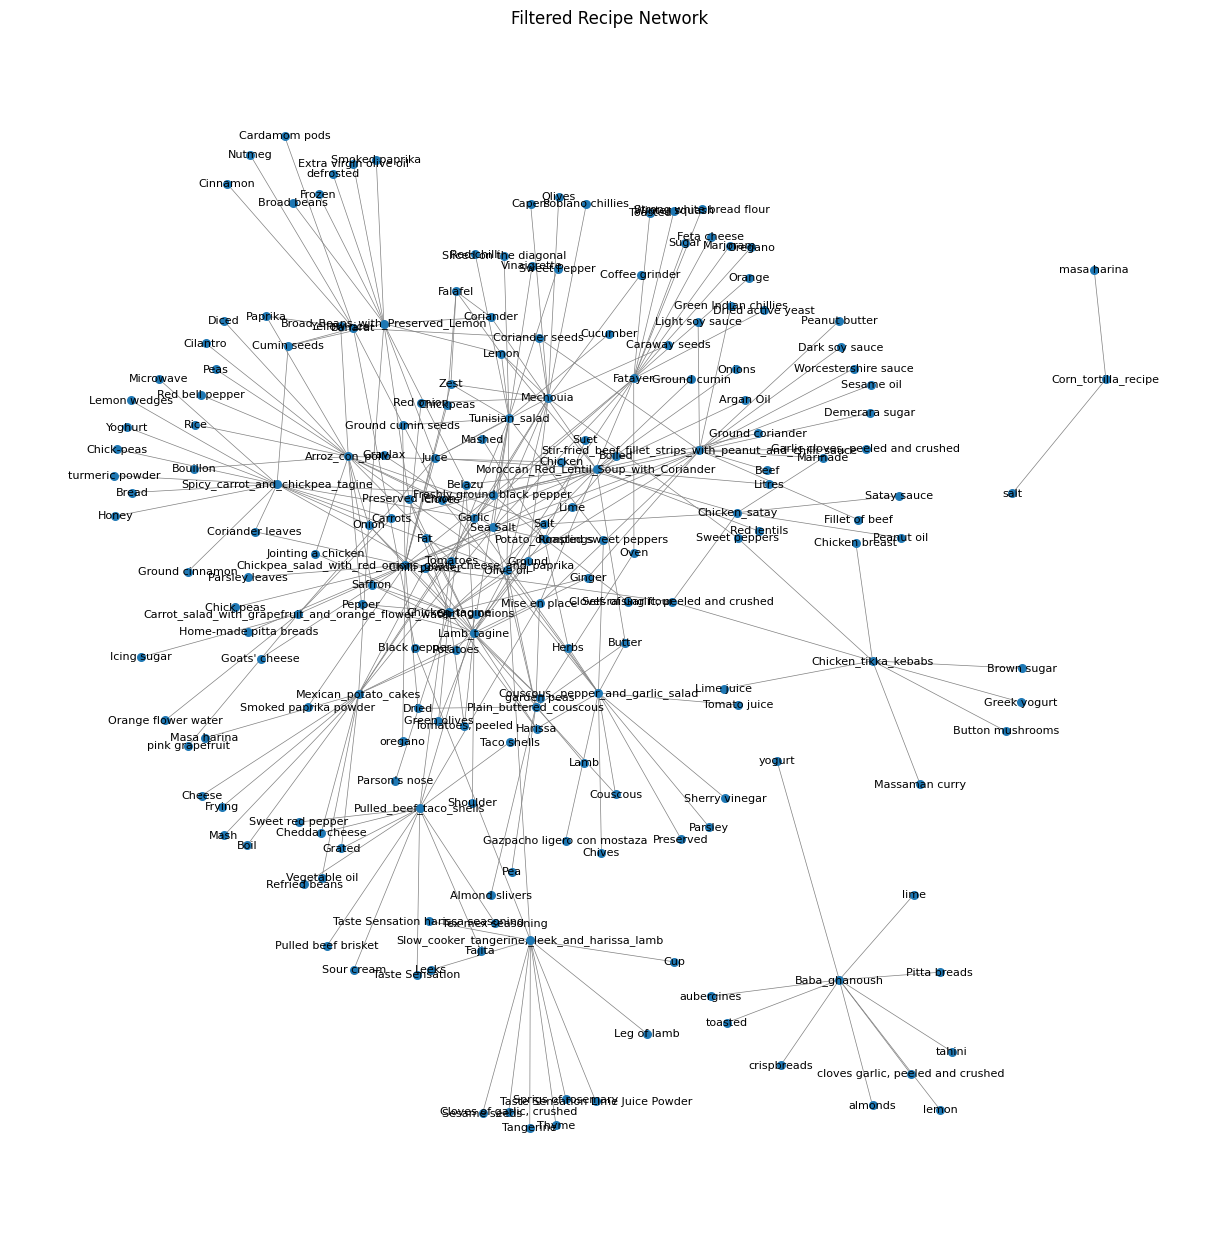

In [6]:
# Different layout and visualization adjustments
pos = nx.spring_layout(subgraph, k=0.15, iterations=20)

plt.figure(figsize=(12, 12))
nx.draw(
    subgraph,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

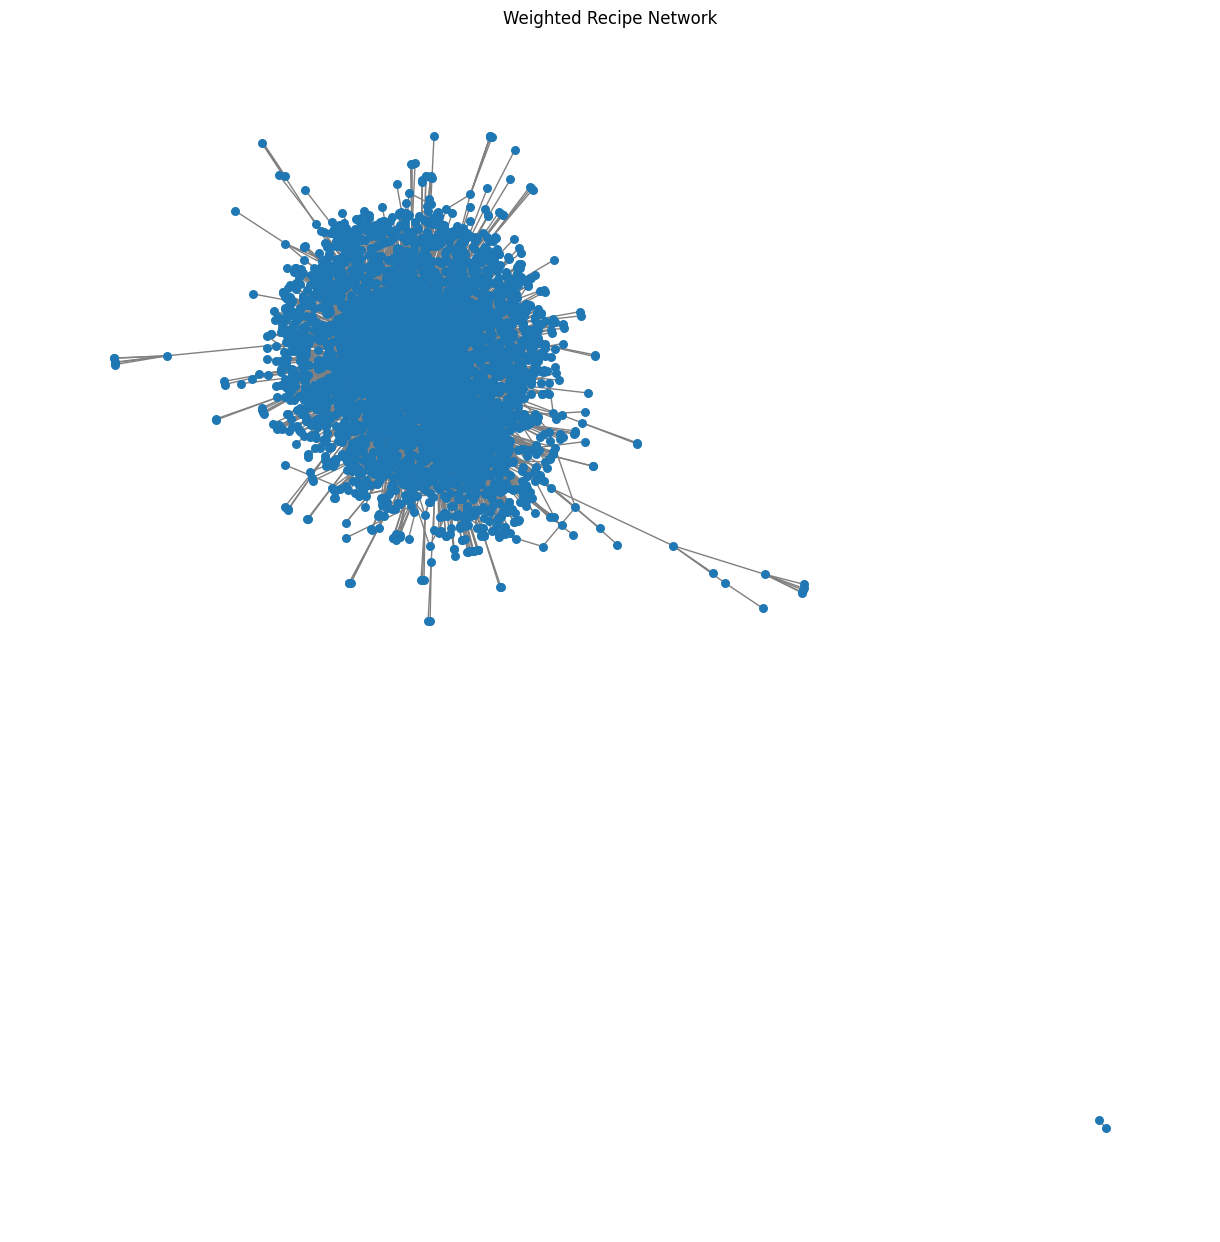

In [2]:
import os
import re
import csv
import networkx as nx
import matplotlib.pyplot as plt


# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return ingredients  # Return a list of ingredients
    else:
        return []


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    ingredient_count = {}  # Dictionary to count ingredient occurrences

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            # Count occurrences of each ingredient across different recipes
            if ingredient in ingredient_count:
                ingredient_count[ingredient] += 1
            else:
                ingredient_count[ingredient] = 1

    for ingredient, count in ingredient_count.items():
        if not graph.has_node(ingredient):
            graph.add_node(ingredient)

        # Add an edge between the recipe and the ingredient with weight (based on count)
        graph.add_edge(recipe, ingredient, weight=count)


# Initialize an undirected graph
graph = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph with weighted edges
                    add_edges(graph, title, ingredients, country)

# Plotting the weighted graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph)
edge_weights = [graph[u][v]["weight"] for u, v in graph.edges]

nx.draw(
    graph,
    pos,
    node_size=30,
    font_color="black",
    width=edge_weights,  # Use edge weights for varying edge thickness
    edge_color="gray",
)
plt.title("Weighted Recipe Network")
plt.show()